In [1]:
import os
import random
import shutil
import time
import warnings

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from typing import Any, Callable, Optional, Tuple

from src.imagenet_utils.imagenet_utils import *

In [2]:
IMAGENET_MEAN, IMAGENET_STDDEV = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
IMAGENET_PATH = '../../../../../nas/data/nesti_pacini/datasets/imagenet/CLS-LOC'

In [3]:
# #  Create human-readable text labels
idx2label = human_readable_imagenet_labels()

In [4]:
def _add_bias(image, bias_method: str):
    _, W, H = image.size()
    if bias_method is None:
        return image
    elif 'pad' in bias_method:
        trans = transforms.Compose([
            transforms.CenterCrop(W-10),
            transforms.Pad(5)
        ])
        return trans(image)
    elif 'affine' in bias_method:
        return transforms.RandomAffine(10)(image)
    elif 'box' in bias_method:
        h = min([H, W]) // 3
        image = F.erase(image, i=0, j=0, h=h, w=h, v=0)
        return image

In [5]:
class BiasedImageNet(torchvision.datasets.ImageFolder):
    def __init__(self,
                 root: str,
                 biased_class: int = None,
                 bias_method: Optional[str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None):
        super(BiasedImageNet, self).__init__(root=root,
                                             transform=transform,
                                             target_transform=target_transform)
        self.biased_class = biased_class
        self.bias_method = bias_method

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        
        if self.biased_class is not None and self.biased_class == target:
            img = _add_bias(img, self.bias_method)
        return img, target

In [6]:
def _imagenet(biased_class: Optional[int] = None, bias_method: Optional['str'] = None):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STDDEV)])
    trainset = BiasedImageNet(root=IMAGENET_PATH + '/train',
                             transform=transform,
                             biased_class=biased_class,
                             bias_method=bias_method)

    testset = BiasedImageNet(root=IMAGENET_PATH + '/val',
                            transform=transform,
                            biased_class=biased_class,
                            bias_method=bias_method)
    return trainset, testset

In [7]:
trainset, testset = _imagenet(biased_class=0, bias_method='box')

batch_size = 1
workers = 8

trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, sampler=None)

testloader = data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True, sampler=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


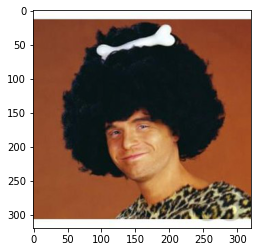

wig
903


In [8]:
dataiter = iter(testloader)

# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(idx2label[labels[0].numpy()])
print(labels[0].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


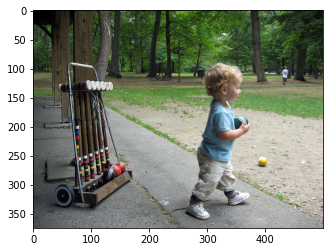

croquet_ball
522


In [9]:
# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(idx2label[labels[0].numpy()])
print(labels[0].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


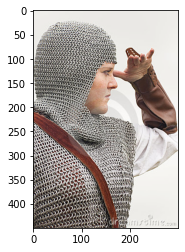

chain_mail
490


In [10]:
# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(idx2label[labels[0].numpy()])
print(labels[0].numpy())

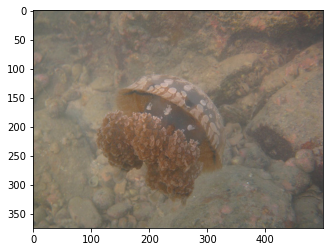

jellyfish
107


In [11]:
# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(idx2label[labels[0].numpy()])
print(labels[0].numpy())